In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import resample

In [3]:
# Load CSV
labels_df = pd.read_csv('train_data.csv')

# Ensure directory exists
train_dir = "Train"
if not os.path.exists(train_dir):
    raise FileNotFoundError(f"Directory '{train_dir}' not found!")

In [4]:
# Calculate class weights dynamically
class_counts = labels_df["label"].value_counts()
total_samples = class_counts.sum()
class_labels = class_counts.index.tolist()
class_weights = {label: total_samples / (count * len(class_labels)) for label, count in class_counts.items()}

# Oversampling to balance dataset
max_count = labels_df["label"].value_counts().max()
over_sampled_df = labels_df.groupby("label", group_keys=False).apply(
    lambda x: resample(x, replace=True, n_samples=max_count, random_state=42)
).reset_index(drop=True)

C:\Users\Acer\AppData\Local\Temp\ipykernel_14372\3868737251.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  over_sampled_df = labels_df.groupby("label", group_keys=False).apply(


In [5]:
# Correct image paths
over_sampled_df["images"] = over_sampled_df["images"].apply(lambda x: os.path.join(train_dir, x))

# Train-Validation-Test Split
train_df, test_df = train_test_split(over_sampled_df, test_size=0.2, random_state=42, stratify=over_sampled_df["label"])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["label"])

# Verify data splits
print("Train Labels:", train_df["label"].value_counts())
print("Val Labels:", val_df["label"].value_counts())
print("Test Labels:", test_df["label"].value_counts())

Train Labels: label
New Castle Disease    1680
Salmonella            1680
Coccidiosis           1680
Healthy               1680
Name: count, dtype: int64
Val Labels: label
Salmonella            420
Healthy               420
Coccidiosis           420
New Castle Disease    420
Name: count, dtype: int64
Test Labels: label
Salmonella            525
New Castle Disease    525
Coccidiosis           525
Healthy               525
Name: count, dtype: int64


In [6]:
# Image augmentation
img_size = (224, 224)
batch_size = 32
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)
t_and_v_gen = ImageDataGenerator()

# Data generators
train_gen = datagen.flow_from_dataframe(train_df, x_col="images", y_col="label",
                                        target_size=img_size, class_mode="categorical",
                                        color_mode="rgb", shuffle=True, batch_size=batch_size)
valid_gen = t_and_v_gen.flow_from_dataframe(val_df, x_col="images", y_col="label",
                                            target_size=img_size, class_mode="categorical",
                                            color_mode="rgb", shuffle=False, batch_size=batch_size)
test_gen = t_and_v_gen.flow_from_dataframe(test_df, x_col="images", y_col="label",
                                           target_size=img_size, class_mode="categorical",
                                           color_mode="rgb", shuffle=False, batch_size=batch_size)


Found 6720 validated image filenames belonging to 4 classes.
Found 1680 validated image filenames belonging to 4 classes.
Found 2100 validated image filenames belonging to 4 classes.


In [7]:
# Get number of classes
num_classes = len(train_gen.class_indices)
print(f"Number of classes: {num_classes}")

# Define Model
img_shape = (224, 224, 3)
base_model = MobileNetV3Small(weights="imagenet", include_top=False, input_shape=img_shape, pooling="max")

# Freeze initial layers to prevent overfitting
for layer in base_model.layers[:50]:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


Number of classes: 4


In [8]:
# Compile model with adjusted learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)


In [9]:
# Train model
history = model.fit(train_gen,
                    validation_data=valid_gen,
                    epochs=10,
                    callbacks=[early_stop, checkpoint, reduce_lr])

c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5687 - loss: 1.0317

210/210 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.5694 - loss: 1.0301 - val_accuracy: 0.8923 - val_loss: 0.3586 - learning_rate: 1.0000e-04
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.8995 - loss: 0.2967

210/210 ━━━━━━━━━━━━━━━━━━━━ 122s 579ms/step - accuracy: 0.8996 - loss: 0.2965 - val_accuracy: 0.9143 - val_loss: 0.2531 - learning_rate: 1.0000e-04
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.9402 - loss: 0.1725

210/210 ━━━━━━━━━━━━━━━━━━━━ 120s 570ms/step - accuracy: 0.9402 - loss: 0.1726 - val_accuracy: 0.9375 - val_loss: 0.1793 - learning_rate: 1.0000e-04
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.9578 - loss: 0.1318

210/210 ━━━━━━━━━━━━━━━━━━━━ 121s 576ms/step - accuracy: 0.9578 - loss: 0.1318 - val_accuracy: 0.9649 - val_loss: 0.1008 - learning_rate: 1.0000e-04
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.9650 - loss: 0.1019

210/210 ━━━━━━━━━━━━━━━━━━━━ 121s 577ms/step - accuracy: 0.9650 - loss: 0.1020 - val_accuracy: 0.9714 - val_loss: 0.0899 - learning_rate: 1.0000e-04
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.9709 - loss: 0.0858

210/210 ━━━━━━━━━━━━━━━━━━━━ 122s 576ms/step - accuracy: 0.9709 - loss: 0.0858 - val_accuracy: 0.9756 - val_loss: 0.0808 - learning_rate: 1.0000e-04
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.9729 - loss: 0.0752

210/210 ━━━━━━━━━━━━━━━━━━━━ 120s 572ms/step - accuracy: 0.9729 - loss: 0.0752 - val_accuracy: 0.9804 - val_loss: 0.0629 - learning_rate: 1.0000e-04
Epoch 8/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9782 - loss: 0.0640

210/210 ━━━━━━━━━━━━━━━━━━━━ 121s 572ms/step - accuracy: 0.9782 - loss: 0.0640 - val_accuracy: 0.9875 - val_loss: 0.0461 - learning_rate: 1.0000e-04
Epoch 9/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 170s 807ms/step - accuracy: 0.9803 - loss: 0.0548 - val_accuracy: 0.9881 - val_loss: 0.0486 - learning_rate: 1.0000e-04
Epoch 10/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.9867 - loss: 0.0444

210/210 ━━━━━━━━━━━━━━━━━━━━ 118s 562ms/step - accuracy: 0.9867 - loss: 0.0444 - val_accuracy: 0.9899 - val_loss: 0.0458 - learning_rate: 1.0000e-04


In [11]:
model.save("best_model.keras")


In [12]:
# Evaluate model
test_loss, test_acc = model.evaluate(test_gen)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 332ms/step - accuracy: 0.9810 - loss: 0.0634
Test Loss: 0.05883821099996567
Test Accuracy: 0.9842857122421265


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


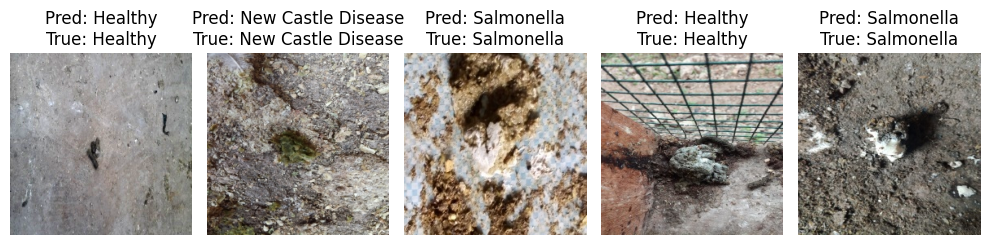

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Get class labels from test generator
class_names = list(test_gen.class_indices.keys())

# Get a batch of images and labels from test generator
batch = next(test_gen)
images, labels = batch

# Make predictions
preds = model.predict(images)

# Visualize predictions
plt.figure(figsize=(10, 5))
for i in range(5):  # Show 5 images
    plt.subplot(1, 5, i+1)
    plt.imshow((images[i] - images[i].min()) / (images[i].max() - images[i].min()))  # Normalize between 0-1

    true_label = np.argmax(labels[i])       # Get true label index
    pred_label = np.argmax(preds[i])        # Get predicted label index
    plt.title(f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}")
    plt.axis("off")

plt.tight_layout()
plt.show()



66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 186ms/step


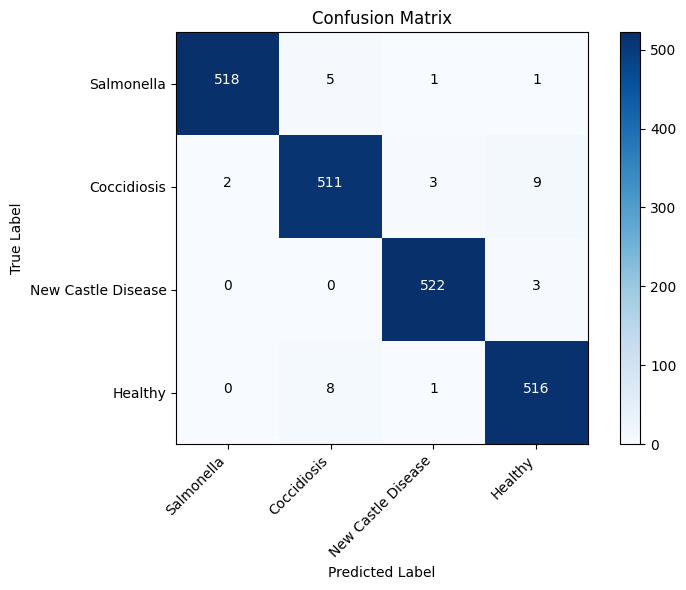


Classification Report:
----------------------
                     precision    recall  f1-score   support

        Salmonella     0.9962    0.9867    0.9914       525
       Coccidiosis     0.9752    0.9733    0.9743       525
New Castle Disease     0.9905    0.9943    0.9924       525
           Healthy     0.9754    0.9829    0.9791       525

          accuracy                         0.9843      2100
         macro avg     0.9843    0.9843    0.9843      2100
      weighted avg     0.9843    0.9843    0.9843      2100



In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Get the class labels from the dataset
classes = list(labels_df["label"].unique())
num_classes = len(classes)

# Predict labels for the test data
predictions = model.predict(test_gen)
y_true = test_gen.classes  # Actual labels
y_pred = np.argmax(predictions, axis=1)  # Predicted labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Set class labels on axes
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, classes, rotation=45, ha="right")  # Rotated for better readability
plt.yticks(tick_marks, classes)

# Add labels to each cell
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Generate and print classification report
clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
print("\nClassification Report:\n----------------------\n", clr)

66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 319ms/step


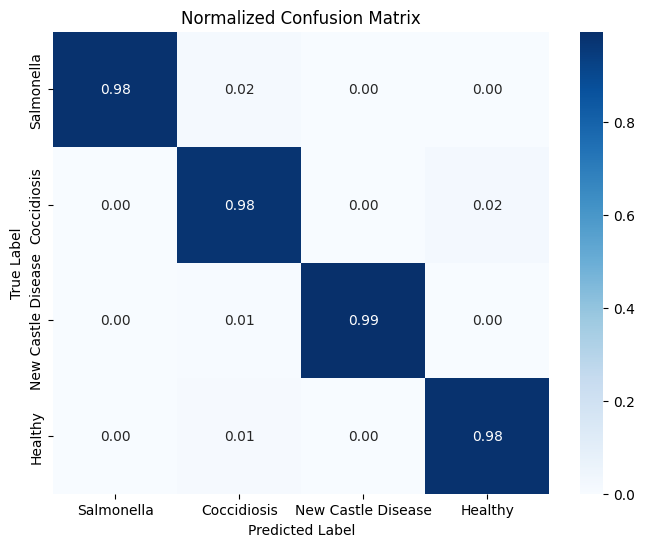

Accuracy: 0.9848
Precision: 0.9849
Recall: 0.9848
F1-Score: 0.9848


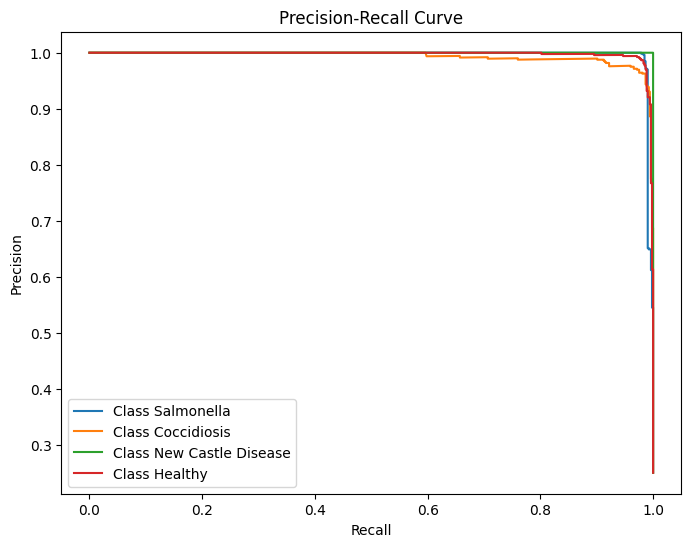

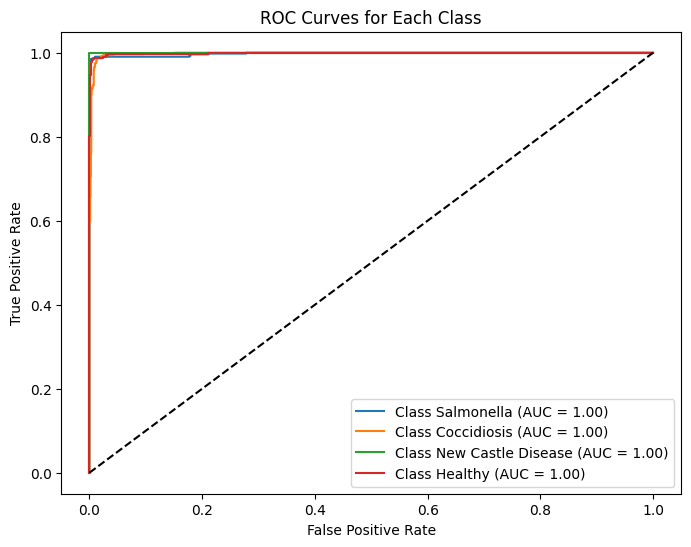

In [20]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
)

classes = list(labels_df["label"].unique())
num_classes = len(classes)

predictions = model.predict(test_gen)
y_true = test_gen.classes  # Actual labels
y_pred = np.argmax(predictions, axis=1)  # Predicted labels

cm = confusion_matrix(y_true, y_pred)

#  Normalized Confusion Matrix (Percentage-based)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()


#  Performance Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

#  Precision-Recall Curve
y_true = np.array(y_true)  # Ensure y_true is a NumPy array

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve((y_true == i).astype(int), predictions[:, i])
    plt.plot(recall, precision, label=f"Class {classes[i]}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()

# ROC Curve & AUC Score (for multi-class)
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true == i, predictions[:, i])  # Compute ROC for each class
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {classes[i]} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random performance)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend(loc="lower right")
plt.show()
